In [1]:
%load_ext autoreload
%autoreload 2
'''
Example of how to use the library for learning using the PILCO learner on the cartpole task
'''
# pylint: disable=C0103
import atexit
import sys
import os
import numpy as np
import kusanagi.ghost.regression as kreg

from kusanagi import utils
from kusanagi.shell.cartpole import default_params
from kusanagi.ghost.learners.PILCO import PILCO, MC_PILCO
from kusanagi.ghost.control import NNPolicy
from kusanagi.utils import plot_results

#np.random.seed(31337)
np.set_printoptions(linewidth=500)

In [2]:
# setup output directory
utils.set_output_dir(os.path.join(utils.get_output_dir(), 'cartpole'))

use_bnn = True
J = 4                                                       # number of random initial trials
N = 100                                                     #learning iterations
pilco_config = default_params()
# initialize learner params for PILCO
pilco_config['params']['use_empirical_x0'] = True
pilco_config['params']['realtime'] = False
pilco_config['params']['H'] = 4.0
pilco_config['params']['plant']['dt'] = 0.1
pilco_config['params']['plant']['params']['l'] = .6
pilco_config['params']['cost']['pendulum_length'] = .6

# create copy of params for MC-PILCO
mcpilco_config = pilco_config.copy()
mcpilco_config['params']['min_method'] = 'ADAM'
mcpilco_config['params']['learning_rate'] = 1e-4
mcpilco_config['params']['max_evals'] = 1000
mcpilco_config['params']['clip'] = 10.0
mcpilco_config['n_samples'] = 25
mcpilco_config['dynmodel_class'] = kreg.BNN
mcpilco_config['policy_class'] = NNPolicy

# init learners
pilco = PILCO(**pilco_config)
mcpilco = MC_PILCO(**mcpilco_config)
mcpilco.resample = False

# share experience and policy between the two learners
mcpilco.experience = pilco.experience
mcpilco.policy = pilco.policy

# gather data with random trials on the pilco learner
for i in range(J):
    pilco.plant.reset_state()
    pilco.apply_controller(random_controls=True)
#pilco.plant.reset_state()
#pilco.apply_controller()

[2017-06-06 17:53:06.465403] RBFPolicy_sat > Initializing parameters
[2017-06-06 17:53:06.475548] RBFPolicy_sat > Initialising expression graph for full GP training loss function
[2017-06-06 17:53:06.629491] RBFPolicy_sat > Initialising expression graph for prediction
[2017-06-06 17:53:06.646862] RBFPolicy_sat > Compiling mean and variance of prediction
[2017-06-06 17:53:08.121356] RBFPolicy_sat > Done compiling
[2017-06-06 17:53:08.146545] Experience > Initialising new experience dataset
[2017-06-06 17:53:08.147322] PILCO > Initialising new PILCO learner
<class 'kusanagi.ghost.control.control_.NNPolicy'> True
[2017-06-06 17:53:08.150988] Experience > Initialising new experience dataset
[2017-06-06 17:53:08.151799] MC_PILCO > Initialising new MC_PILCO learner
[2017-06-06 17:53:08.154446] Cartpole > Reset to inital state
[2017-06-06 17:53:08.155437] PILCO > Compiling cost function
[2017-06-06 17:53:08.156189] PILCO > Cost parameters: {'target': [0, 0, 0, 3.141592653589793], 'width': 0.2

In [10]:
pilco.train_dynamics()

[2017-06-06 18:04:24.690027] PILCO > Training dynamics model
[2017-06-06 18:04:24.692013] PILCO > Dataset size:: Inputs: [ (200, 6) ], Targets: [ (200, 4) ]  
[2017-06-06 18:04:24.693643] GP_UI > Current hyperparameters:
[array([[ 4.47585927,  2.41325762,  3.13987477,  0.83625627,  2.38295414,  4.34708463, -0.90054098, -4.2536078 ],
       [ 4.6548518 ,  4.4949254 ,  2.16087108,  0.22689674,  0.28207769,  3.52325511,  0.50776036, -4.19007043],
       [ 4.63684126,  4.23627215,  2.11498248, -0.01542999, -0.08655874,  3.18472293,  1.16951551, -3.41913454],
       [ 4.54301605,  4.49800617,  3.06278485,  0.49206489,  0.92906942,  4.09478206, -0.12887612, -4.23076671]])]
[2017-06-06 18:04:24.702315] GP_UI > loss: [-506.36739149 -321.77108988 -132.6833862  -467.44632166]
[2017-06-06 18:04:24.710174] GP_UI > Using L-BFGS-B optimizer
[2017-06-06 18:04:25.347946] GP_UI > -1432.05907635[2017-06-06 18:04:25.348743] GP_UI > 
[2017-06-06 18:04:25.350903] GP_UI > New hyperparameters:
[[ 4.48720368 

In [12]:
mcpilco.train_dynamics(max_episodes=4)

[2017-06-06 18:05:33.710980] MC_PILCO > Training dynamics model
[2017-06-06 18:05:33.712003] MC_PILCO > Dataset size:: Inputs: [ (160, 6) ], Targets: [ (160, 4) ]  
[2017-06-06 18:05:55.046610] BNN > iter: 5001, loss: -2.041636E+00, error: 7.203801E-02, elapsed: 2.992630E-03, sn2: [ 0.00057187  0.02512763  0.20815579  0.00250935]
[2017-06-06 18:05:55.047550] MC_PILCO > Done training dynamics model


[2017-06-06 18:07:27.382687] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-06-06 18:07:27.706966] MC_PILCO > Compiling trajectory rollout function
[2017-06-06 18:07:29.362023] MC_PILCO > Done compiling.


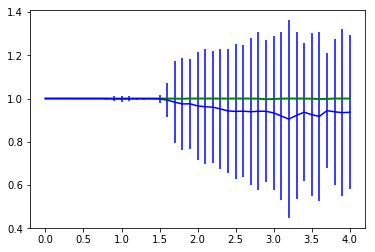

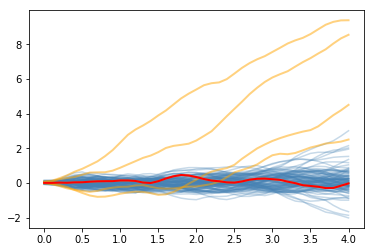

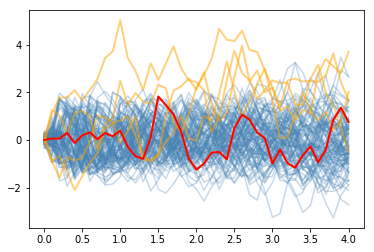

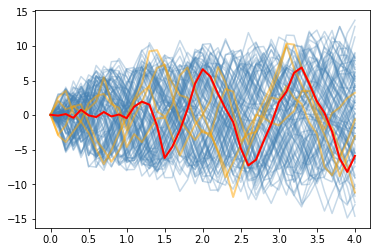

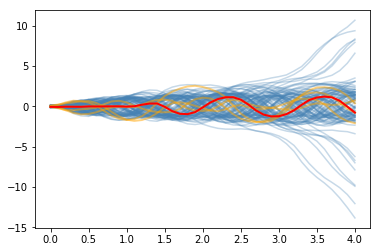

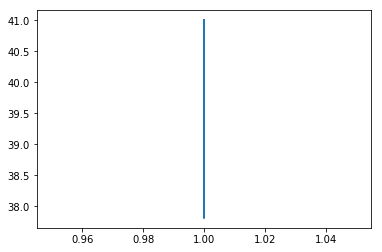

/home/juancamilog/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [13]:
mcpilco.resample = False
mcpilco.rollout_fn = None
mcpilco.set_n_samples(100)
plot_results(mcpilco,plot_samples=True)

[2017-06-06 18:07:33.158000] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-06-06 18:07:33.584153] MC_PILCO > Compiling trajectory rollout function
[2017-06-06 18:07:36.655960] MC_PILCO > Done compiling.


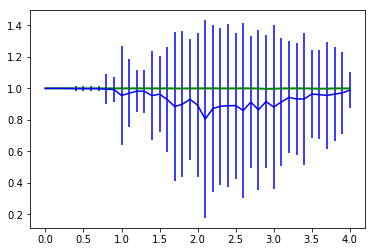

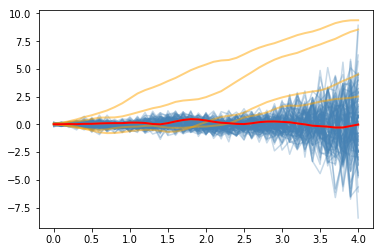

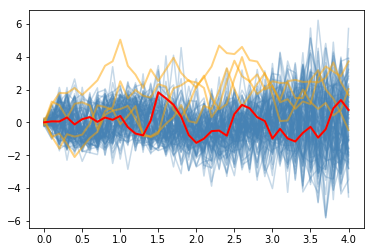

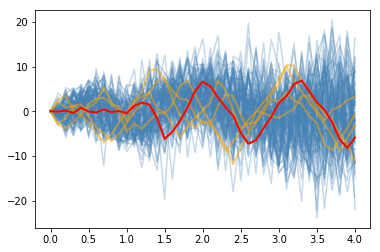

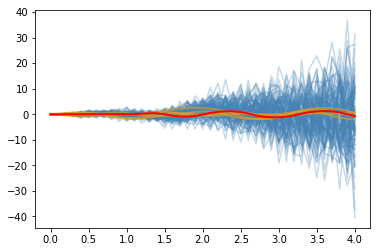

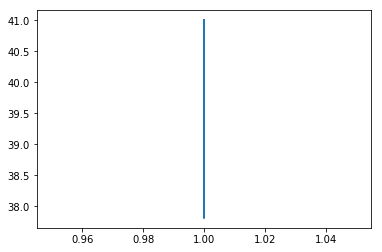

/home/juancamilog/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [14]:
mcpilco.resample = True
mcpilco.rollout_fn = None
mcpilco.set_n_samples(100)
plot_results(mcpilco,plot_samples=True)

[2017-06-06 18:08:02.212765] plot_results > Predicted value: [40.016906]


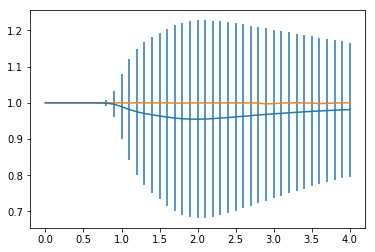

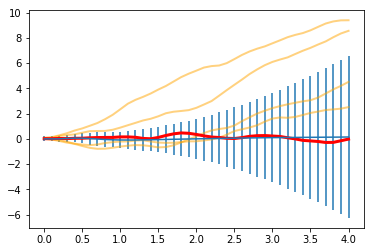

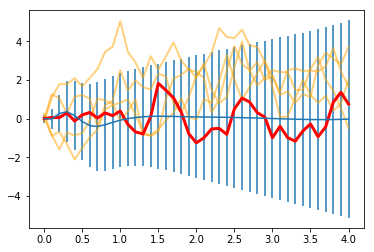

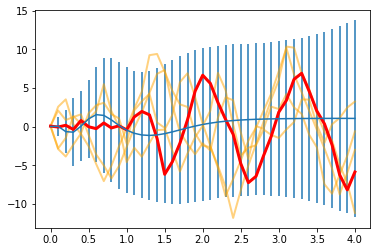

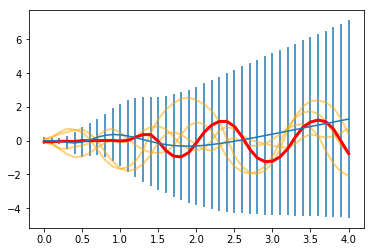

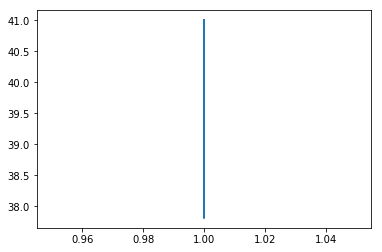

/home/juancamilog/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [16]:
plot_results(pilco)

In [9]:
#resample = True
#n_samples = 25
#mcpilco.learning_rate = 1e-4
#if mcpilco.trajectory_samples.get_value() != n_samples or mcpilco.resample != resample:
#    mcpilco.resample = resample
#    mcpilco.set_n_samples(n_samples)
#    mcpilco.rollout_fn = None
#    mcpilco.train_fn = None
mcpilco.set_n_samples(25)
mcpilco.learning_rate = 1e-4
# train
mcpilco.train_policy()
# apply controller
mcpilco.plant.reset_state()
mcpilco.apply_controller()

[2017-06-06 17:59:14.954310] MC_PILCO > Training policy parameters [Iteration 1]
[2017-06-06 17:59:15.008597] MC_PILCO > Initial value estimate [39.896528]
[2017-06-06 17:59:15.009338] MC_PILCO > Using ADAM optimizer
[2017-06-06 17:59:15.009970] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-06-06 17:59:15.394911] MC_PILCO > Compiling optimizer
[2017-06-06 17:59:15.396092] MC_PILCO > Computing symbolic expression for policy gradients
[2017-06-06 17:59:45.640741] MC_PILCO > Done compiling.
[2017-06-06 18:03:04.577399] MC_PILCO > Current value: 3.866899E+01, Total evaluations: 1000, gm: [9.7027027229153369, 2.3303098413609775, 0.65361748128431318], lr: 0.000100
[2017-06-06 18:03:04.621872] MC_PILCO > Done training. New value [37.605861] iter: [765]
[2017-06-06 18:03:04.622671] Cartpole > Reset to inital state
[2017-06-06 18:03:04.623885] MC_PILCO > Compiling cost function
[2017-06-06 18:03:04.624808] MC_PILCO > Cost parameters: {'target': [0, 0, 0, 3.14

In [9]:
#mcpilco.save()